## Computing EERs Using Simple Threshold Analysis

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

In [18]:
DATA_FILES=glob.glob("data/*.csv")
THRESHOLDS=125
print(DATA_FILES)
sensor_frames = [pd.read_csv(file) for file in DATA_FILES]

['data/Light.csv', 'data/LinearAcceleration.csv', 'data/Accelerometer.csv', 'data/Gyroscope.csv', 'data/Gravity.csv', 'data/RotationVector.csv', 'data/MagneticField.csv']


In [21]:
def mae(a, b):
    """ Mean absolute error """
    return np.mean(np.abs(a - b))

def corr(a, b):
    """ Pearson's Correlation Coefficient """
    return np.corrcoef(a, b)[0,1]

def cross_corr(a, b):
    """ Cross correlation """
    return np.correlate(a, b)

def apply_metric(shared_group, f, d, key):
    """ Iterates each group of shared_group, applies
    similarity metric, f, and inserts into d[key] """
    for shared_id,group in shared_group:
        a,b = group.iloc[:,1:-1].as_matrix()
        try:
            c = f(a,b)
        except Exception:
            c = np.nan
        if not np.isnan(c):
            d[key].append(c)
    
def get_similarities(sensor_frame, f, i): 
    """ Compute similarity metrics for a given frame """
    # Group by legal and illegal transaction groups
    groups = sensor_frame.groupby("genuine_transaction")
    legal_group = groups.get_group(1)
    illegal_group = groups.get_group(0)
    # Group by shared IDs for legal and illegal transactions
    legals = legal_group.groupby("shared_id")
    illegals = illegal_group.groupby("shared_id")
    
    # Apply metrics on +/- data
    data = {'0':[], '1':[]}
    apply_metric(legals, f, data, '1')
    apply_metric(illegals, f, data, '0')
    return data

def find_eer_index(fprs, fnrs):
    """ Returns index of FPR and FNR crossover """
    for i, _ in enumerate(fprs):
        if fnrs[i] < fprs[i]:
            return i
    return None

def compute_eer(negs, poss):
    """ Compute EER for given + and - labelled similarities """
    fprs, fnrs = [], []
    ts = np.linspace(min(min(negs), min(poss)), 
                     max(max(negs), max(poss)),
                     num=THRESHOLDS)
    for t in ts:
        fps, fns, tps, tns = 0, 0, 0, 0
        for n in negs:
            if n < t:
                fps += 1                
            else:
                tns += 1
        for p in poss:
            if p < t:
                tps += 1
            else:
                fns += 1
                
        # Store fpr,fnr for plotting graphs
        fpr = fps / (fps + tns); fprs.append(fpr);
        fnr = fns / (fns + tps); fnrs.append(fnr);
    eer_i = find_eer_index(fprs, fnrs)
    return(fprs, fnrs, fnrs[eer_i], ts[eer_i], ts)

def analyse(data):
    fprs, fnrs, eer, t, ts = compute_eer(data['0'], data['1'])
    print("EER:", eer, "t:",t)
    fig, ax = plt.subplots()
    ax.plot(ts, fprs, 'b--', label='FAR')
    ax.plot(ts, fnrs, 'r', label='FRR')
    ax.legend(loc=1)
    plt.show()

Analysing data/Light.csv
*** MAE ***
EER: 0.3643410852713178 t: 26.1248387097


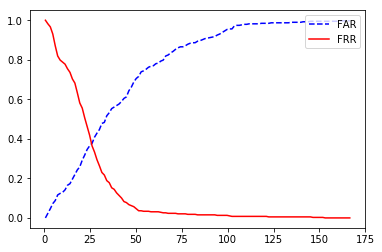

*** CORR ***
EER: 0.432 t: 0.699901698612


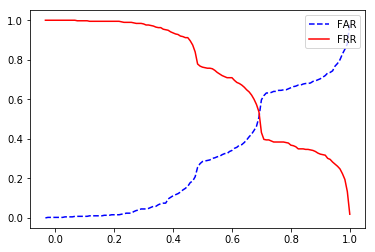

Analysing data/LinearAcceleration.csv
*** MAE ***
EER: 0.5196850393700787 t: 0.557577588765


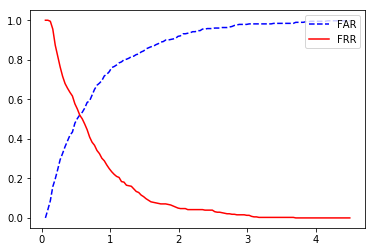

*** CORR ***
EER: 0.45144356955380577 t: 0.0608840602264


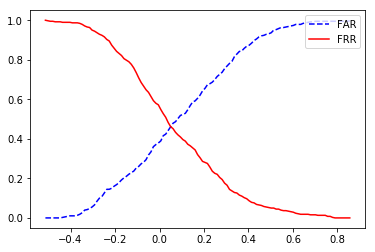

Analysing data/Accelerometer.csv
*** MAE ***
EER: 0.49740932642487046 t: 0.912002528824


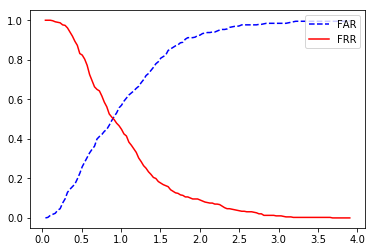

*** CORR ***
EER: 0.5077720207253886 t: 0.501547147265


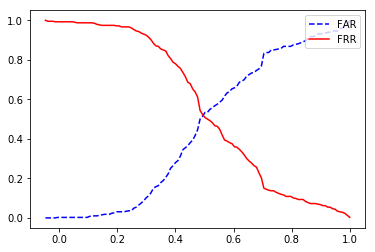

Analysing data/Gyroscope.csv
*** MAE ***
EER: 0.4899497487437186 t: 0.313613761346


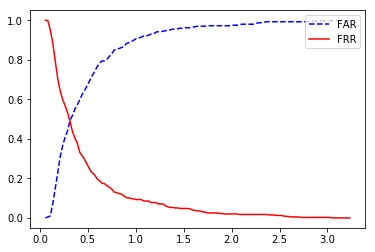

*** CORR ***
EER: 0.5402010050251256 t: 0.332692149886


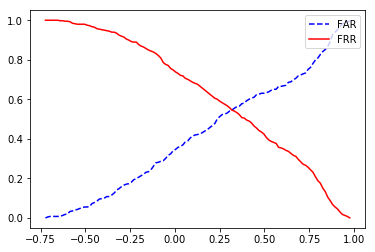

Analysing data/Gravity.csv
*** MAE ***
EER: 0.2895377128953771 t: 0.398593467002


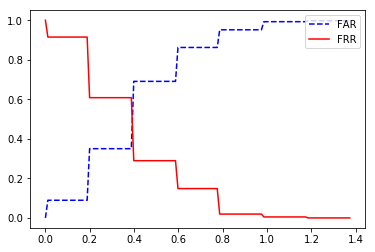

*** CORR ***
EER: 0.48905109489051096 t: 0.485419659642


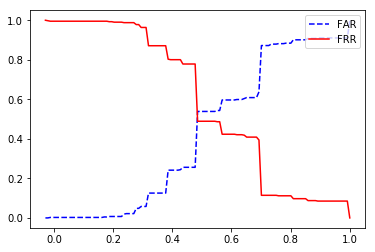

Analysing data/RotationVector.csv
*** MAE ***
EER: 0.33240997229916897 t: 0.512824712206


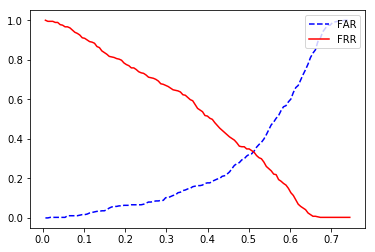

*** CORR ***
EER: 0.41274238227146814 t: 0.481173872661


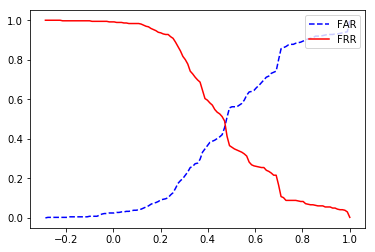

Analysing data/MagneticField.csv
*** MAE ***
EER: 0.3629032258064516 t: 183.473734692


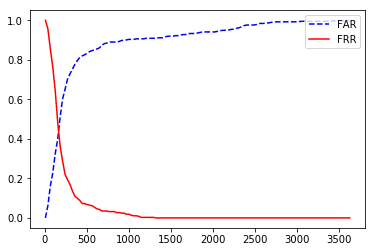

*** CORR ***
EER: 0.5188172043010753 t: 0.403866424955


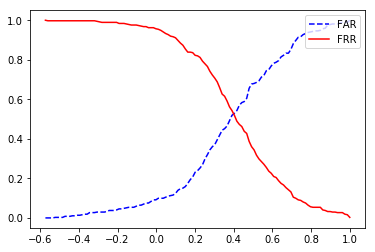

In [20]:
# Compute MAES and Corrs for each sensor frame
for i, sensor_frame in enumerate(sensor_frames):
    print("Analysing", DATA_FILES[i])
    maes = get_similarities(sensor_frame, mae, i)
    corrs = get_similarities(sensor_frame, corr, i)
    print("*** MAE ***")
    analyse(maes)
    print("*** CORR ***")
    analyse(corrs)